In [20]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from utils_SA import simulate_model
import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import matplotlib.pyplot as plt
import time
import json

In [21]:
from inputFactorSpace import input_factor_names, df_input_factors

In [171]:
fn = 'logs/2022-09-05 120006_optimizer_result_log.hdf5'


result = store.read_result(fn, problem=True)

This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within logs/2022-09-05 120006_optimizer_result_log.hdf5.


In [172]:
print((result.optimize_result.summary()))

## Optimization Result 

* number of starts: 100 
* best value: 8458.872233393597, id=60
* worst value: 121176.69504731393, id=40
* number of non-finite values: 0

* execution time summary: 
	Mean execution time: 39.34584509849548s
	Maximum execution time: 77.85188341140747s,	id=89
	Minimum execution time: 1.1102759838104248s,	id=40
* summary of optimizer messages:
	Count	Message
	54	Converged (|f_n-f_(n-1)| ~= 0)
	42	Linear search failed
	3	Converged (|x_n-x_(n-1)| ~= 0)
	1	operands could not be broadcast together with shapes (51,) (50,) 
* best value found (approximately) 8 time(s) 
* number of plateaus found: 10
A summary of the best run:

### Optimizer Result 

* optimizer used: <ScipyOptimizer method=TNC options={'maxiter': 1000, 'disp': False}> 
* message: Converged (|f_n-f_(n-1)| ~= 0) 
* number of evaluations: 9275 
* time taken to optimize: 32.22790312767029 
* startpoint: [ -0.26369814  -0.14775721  -1.8784609   -1.1526215   -2.60281307
  -8.8769132   -7.54826765 -10.95976223

/localdata1/lang_a4/memilio/epi_venv3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

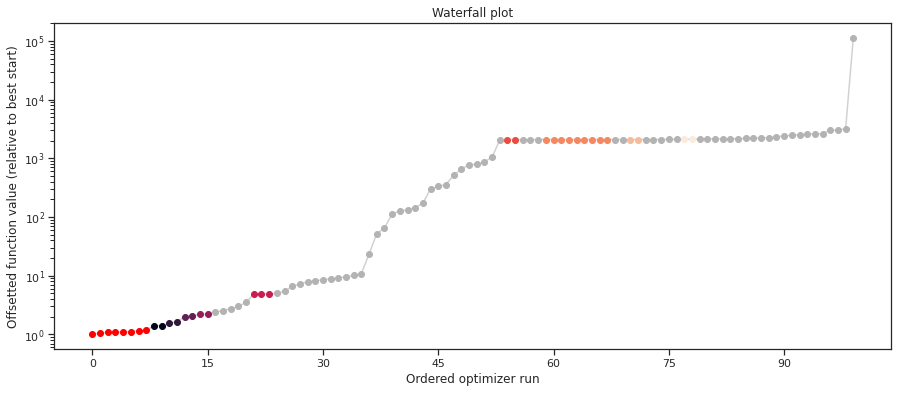

In [79]:
pypesto.visualize.waterfall(result, size=(15, 6))

In [80]:
#problem = problem.read(objective = objective1)

In [81]:
from inputFactorSpace import varying_input_factors

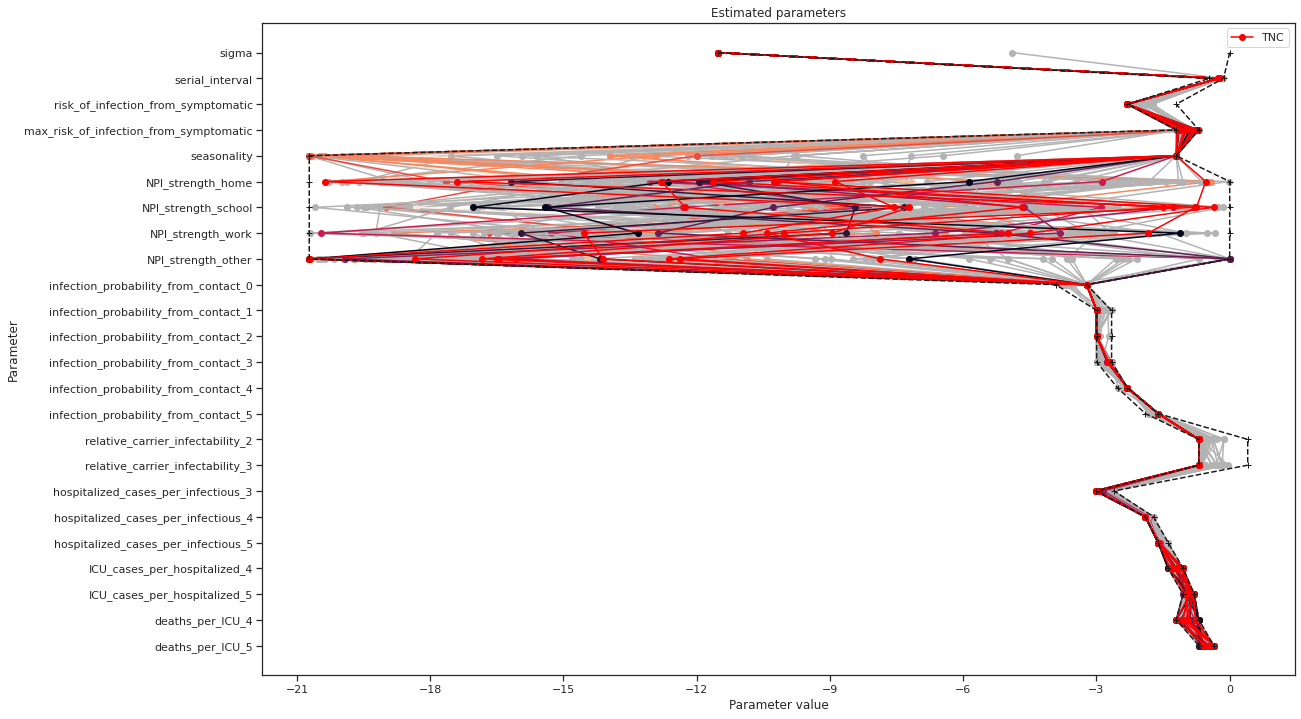

In [82]:
ax = visualize.parameters(
    [result],
    legends=["TNC"],
    balance_alpha=False,
)
ax.set_yticklabels(['sigma']+varying_input_factors)
ax.tick_params(axis='y', rotation=0)
#ax.set_yticklabels(varying_input_factors, rotation=90)

In [83]:
sample.geweke_test(result = result)
print(result.sample_result['burn_in'])

sample.effective_sample_size(result=result)
print(result.sample_result['effective_sample_size'])

Geweke burn-in index: 0


0

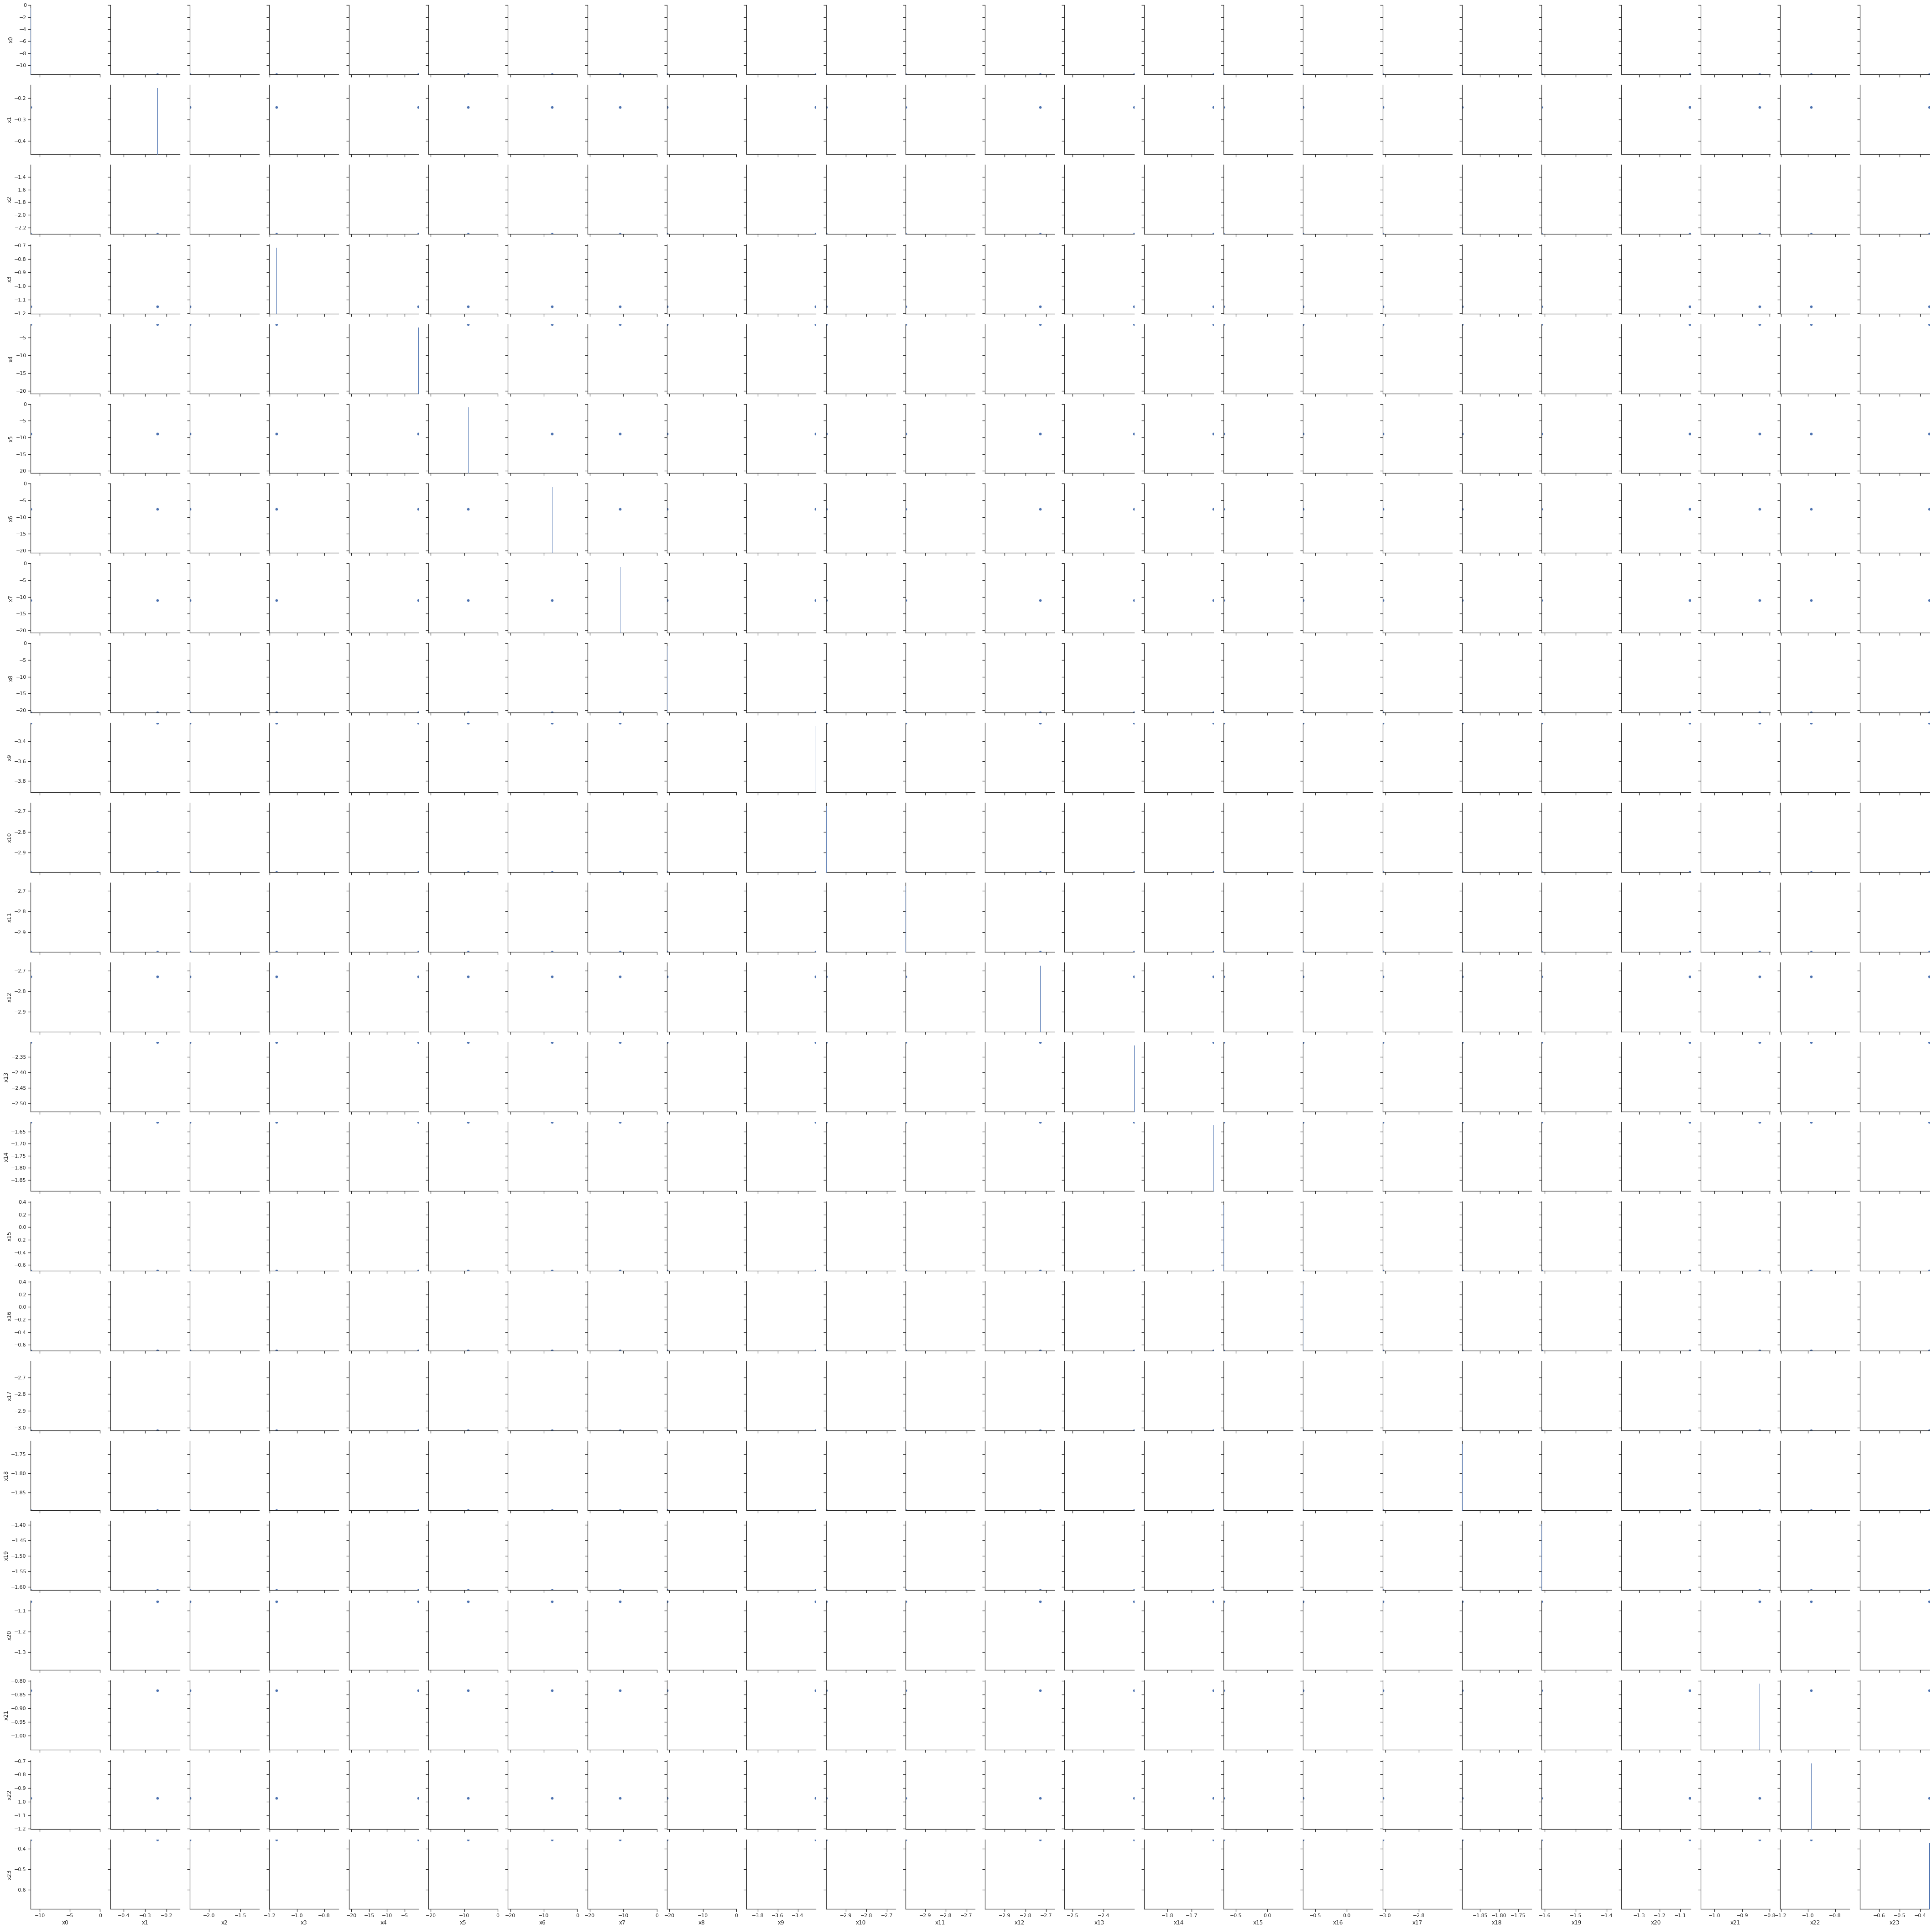

In [85]:
ax = visualize.sampling_scatter(result)
plt.savefig("plots/sample_scatter.png")

### Todos
- how to add samples after saving the result?
- profiles
- remove log scale

In [86]:
nr_params = len(varying_input_factors)+1
num_row = int(np.round(np.sqrt(nr_params)))
num_col = int(np.ceil(nr_params / num_row))

In [119]:
from functools import partial
from matplotlib.ticker import FormatStrFormatter


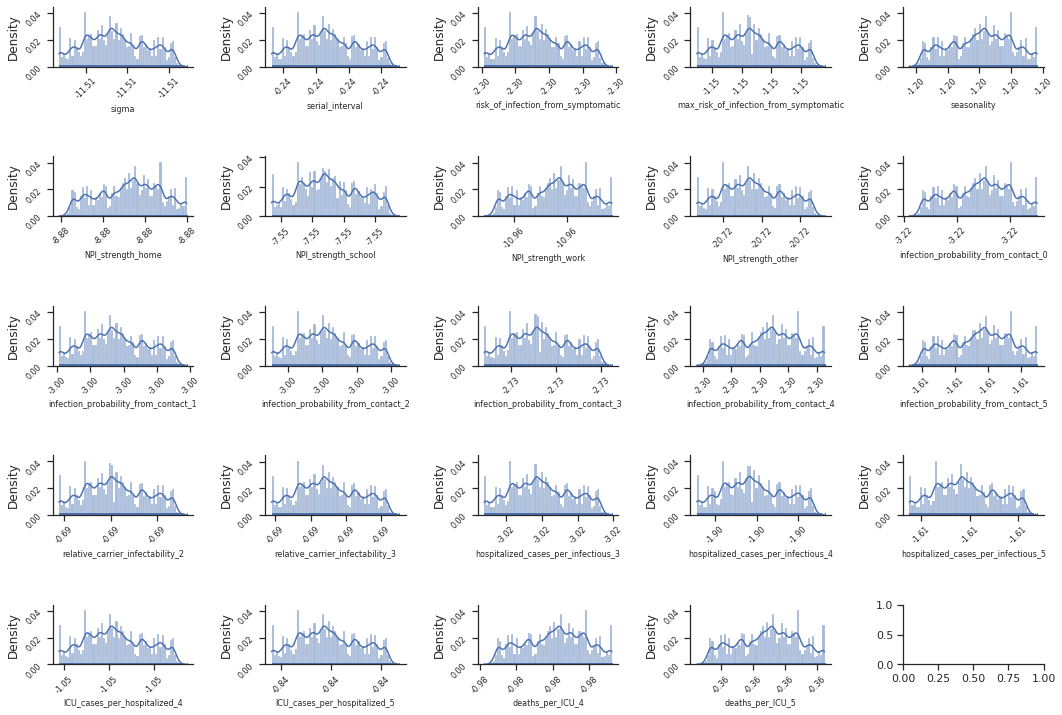

In [120]:
#fig, ax = plt.subplots(num_row, num_col, squeeze=False, figsize=size)
ax = visualize.sampling_1d_marginals(result, size =(15,10))
k = 0
for i in range(num_row):
    for j in range(num_col):
        if k < nr_params:
            ax[i,j].set_xlabel((['sigma']+varying_input_factors)[k], fontsize=8 )
            k += 1
            ax[i,j].tick_params(axis='both', which='major', labelsize=8, labelrotation=45)
            ax[i,j].tick_params(axis='both', which='minor', labelsize=8, labelrotation=45)
            
            #ax[i, j].ticklabel_format(useOffset=False)
            ax[i, j].set_xscale('function', functions=(np.exp, np.log))
            ax[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.subplots_adjust(hspace=1.5)

best values:  [7.85464089e-01 1.00000000e-01 4.95966415e-01 3.00000000e-01
 5.79597104e-05 6.58542928e-02 8.57427242e-07 9.73658298e-05
 4.00000000e-02 5.00000000e-02 5.00000000e-02 6.62319506e-02
 1.00000000e-01 2.00000000e-01 5.00000000e-01 5.00000000e-01
 4.90000000e-02 1.50000000e-01 2.00000000e-01 2.50000000e-01
 3.52715093e-01 4.74876203e-01 5.00166397e-01]
(51, 3)
[2022-09-05 08:17:41.202] [info] Adaptive step sizing successful to tolerances.


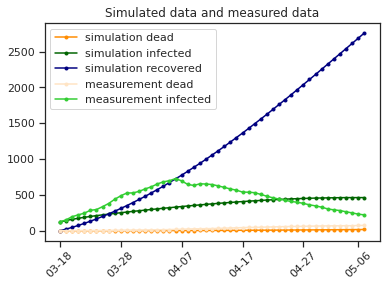

In [57]:
best_values = np.exp(result.optimize_result.as_list()[0]['x'][1:])
print("best values: ", best_values)
static_params['output_index'] = [Compartments.index("Dead"), Compartments.index("Infected"), Compartments.index("Recovered")]
simulation = simulate_model({**static_params, **dict(zip(varying_input_factors, best_values)), **dict_fixed_factors})
print(simulation.shape)

datelist = np.array(pd.date_range(datetime(start_year, start_month,
                        start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1
fig, ax = plt.subplots()
ax.plot(simulation[:, 0], 'o-', markersize = 3, label='simulation dead', color="darkorange") 
ax.plot(simulation[:, 1], 'o-', markersize = 3, label='simulation infected', color="darkgreen") 
ax.plot(simulation[:, 2], 'o-', markersize = 3, label='simulation recovered', color="navy") 
ax.plot(dead_cases, 'o-', markersize = 3, label='measurement dead', color = "bisque")
ax.plot(infected_cases, 'o-', markersize = 3, label='measurement infected', color = "limegreen")
#ax.plot(recovered_cases, 'o-', markersize = 3, label='measurement recovered', color = "royalblue")
ax.set_title("Simulated data and measured data")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range], rotation=45)
ax.legend()
fig.tight_layout
plt.show()
#fig.savefig('plots/'+ time.strftime("%Y-%m-%d %H%M%S") + '_Plot_best_simulation.pdf')
#plt.close()

# Optimization with 80 Parameters

Fragen:
- warum macht es sinn, sigma zu fitten?
- max iter vom optimizer größer?
- auf dead (und infected) fitten
- how to use samples

In [162]:
fn80 = 'logs/2022-09-11 225757_optimizer_result_log.hdf5'
result80 = store.read_result(fn80, problem=True)

This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within logs/2022-09-11 225757_optimizer_result_log.hdf5.


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

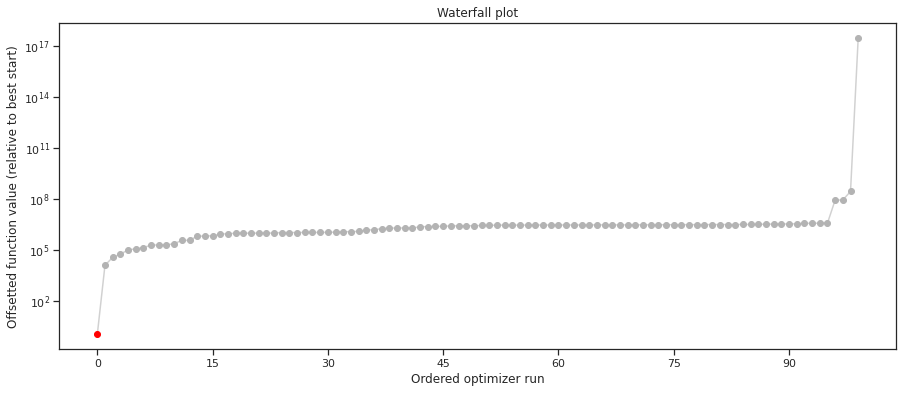

In [163]:
pypesto.visualize.waterfall(result80, size=(15, 6))

In [164]:
print((result80.optimize_result.summary()))

## Optimization Result 

* number of starts: 100 
* best value: 16408.940642749705, id=61
* worst value: 3.143299319800757e+17, id=91
* number of non-finite values: 0

* execution time summary: 
	Mean execution time: 250.8535084962845s
	Maximum execution time: 712.3351838588715s,	id=34
	Minimum execution time: 19.15349793434143s,	id=8
* summary of optimizer messages:
	Count	Message
	54	Linear search failed
	36	Converged (|x_n-x_(n-1)| ~= 0)
	7	Converged (|f_n-f_(n-1)| ~= 0)
	3	Max. number of function evaluations reached
* best value found (approximately) 1 time(s) 
* number of plateaus found: 0
A summary of the best run:

### Optimizer Result 

* optimizer used: <ScipyOptimizer method=TNC options={'maxiter': 2000}> 
* message: Linear search failed 
* number of evaluations: 124148 
* time taken to optimize: 495.5120837688446 
* startpoint: [-10.67230834  -7.87979428   1.89134512  -0.37929647   1.99058972
   1.79416295  -2.24343731  -0.75130849  -7.60877384   0.17028476
 -16.20149919 -12

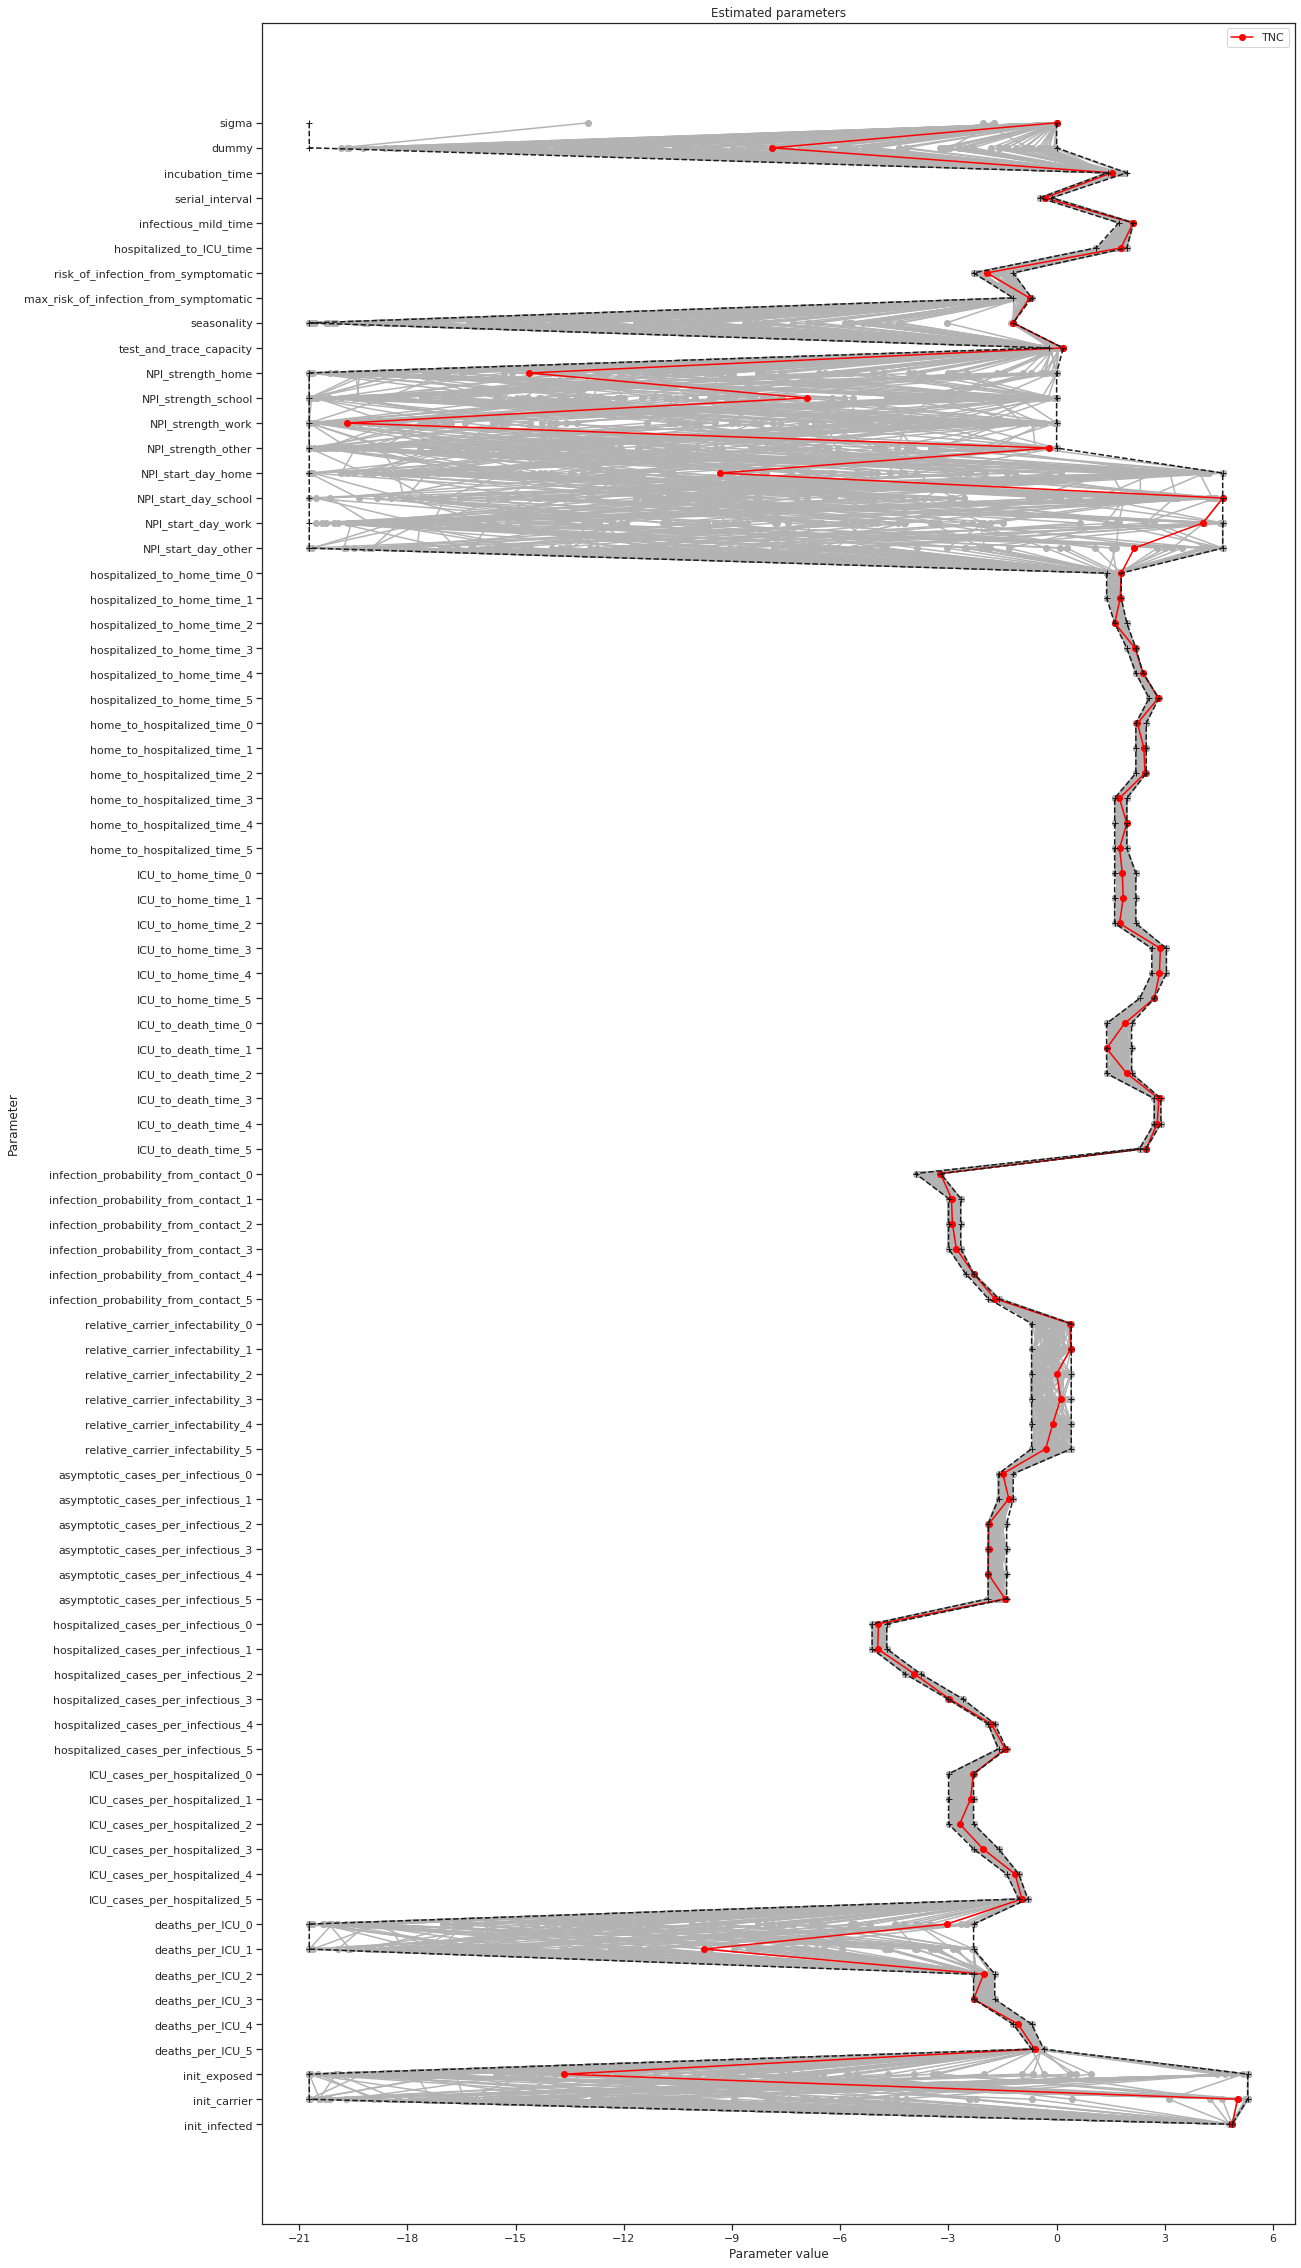

In [166]:
ax = visualize.parameters(
    [result80],
    legends=["TNC"],
    balance_alpha=False,
    #scale_to_interval=[0,1],
)
ax.set_yticklabels(['sigma']+input_factor_names)
ax.tick_params(axis='y', rotation=0)
#ax.set_xscale('function', functions=(np.exp, np.log))

[2022-09-11 23:27:13.999] [info] Adaptive step sizing successful to tolerances.
(51, 3)


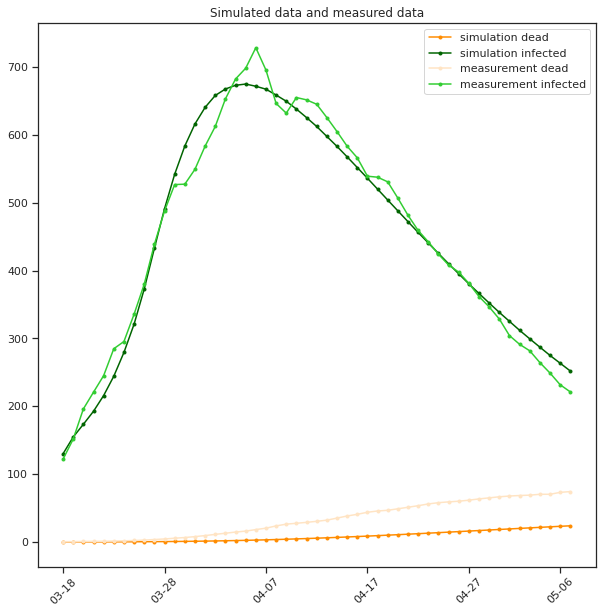

In [167]:
best_values = np.exp(result80.optimize_result.as_list()[0]['x'][1:])
days = 50
#print("best values: ", best_values)
static_params['output_index'] = [Compartments.index("Dead"), Compartments.index("Infected"), Compartments.index("Recovered")]
simulation = simulate_model({**static_params, **dict(zip(input_factor_names, best_values))})
print(simulation.shape)

datelist = np.array(pd.date_range(datetime(start_year, start_month,
                        start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(simulation[:, 0], 'o-', markersize = 3, label='simulation dead', color="darkorange") 
ax.plot(simulation[:, 1], 'o-', markersize = 3, label='simulation infected', color="darkgreen") 
#ax.plot(simulation[:, 2], 'o-', markersize = 3, label='simulation recovered', color="navy") 
ax.plot(dead_cases, 'o-', markersize = 3, label='measurement dead', color = "bisque")
ax.plot(infected_cases, 'o-', markersize = 3, label='measurement infected', color = "limegreen")
#ax.plot(recovered_cases, 'o-', markersize = 3, label='measurement recovered', color = "royalblue")
ax.set_title("Simulated data and measured data")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range], rotation=45)
ax.legend()
fig.tight_layout
plt.show()
#fig.savefig('plots/'+ time.strftime("%Y-%m-%d %H%M%S") + '_Plot_best_simulation.pdf')
#plt.close()

In [168]:
sample.geweke_test(result = result80)
print(result80.sample_result['burn_in'])

sample.effective_sample_size(result=result80)
print(result80.sample_result['effective_sample_size'])

Geweke burn-in index: 70000


70000


Estimated chain autocorrelation: 4191.273015704369
Estimated effective sample size: 7.156261027756408


7.156261027756408


In [169]:
nr_params = len(input_factor_names)+1
num_row = int(np.round(np.sqrt(nr_params)))
num_col = int(np.ceil(nr_params / num_row))

In [ ]:
#fig, ax = plt.subplots(num_row, num_col, squeeze=False, figsize=size)
ax = visualize.sampling_1d_marginals(result80, size =(20,20))
k = 0
for i in range(num_row):
    for j in range(num_col):
        if k < nr_params:
            ax[i,j].set_xlabel((['sigma']+input_factor_names)[k], fontsize=8 )
            k += 1
            ax[i,j].tick_params(axis='both', which='major', labelsize=8, labelrotation=45)
            ax[i,j].tick_params(axis='both', which='minor', labelsize=8, labelrotation=45)
            
            #ax[i, j].ticklabel_format(useOffset=False)
            ax[i, j].set_xscale('function', functions=(np.exp, np.log))
            ax[i, j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.subplots_adjust(hspace=1.5, wspace = 1.2)